### Feature selection: [Use Chi-Square Test and LogReg for data](https://www.kaggle.com/code/maryiaznak/use-chi-square-test-and-logreg-for-data)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/microsoft-malware-prediction/sample_submission.csv
/kaggle/input/microsoft-malware-prediction/train.csv
/kaggle/input/microsoft-malware-prediction/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data loading

In [3]:
column_dtypes = {'IsBeta' : 'Int8',
                 'RtpStateBitfield' : 'Int16',
                 'IsSxsPassiveMode' : 'Int8',
                 'HasTpm' : 'Int8',
                 'CountryIdentifier' : 'Int64',
                 'CityIdentifier' : 'Int64',
                 'OrganizationIdentifier' : 'Int64',
                 'IsProtected' : 'Int8',
                 'AutoSampleOptIn' : 'Int8',
                 'SMode' : 'Int8',
                 'Firewall' : 'Int8',
                 'Census_HasOpticalDiskDrive' : 'Int8',
                 'Census_IsPortableOperatingSystem' : 'Int8',
                 'Census_IsFlightsDisabled' : 'Int8',
                 'Census_IsSecureBootEnabled' : 'Int8',
                 'Census_IsWIMBootEnabled' : 'Int8',
                 'Census_IsVirtualDevice' : 'Int8',
                 'Census_IsTouchEnabled' : 'Int8',
                 'Census_IsPenCapable' : 'Int8',
                 'Census_IsAlwaysOnAlwaysConnectedCapable': 'Int8',
                 'Wdft_IsGamer' : 'Int8',
                 'HasDetections' : 'int'}

In [4]:
columns_to_ignore = ('DefaultBrowsersIdentifier',  # 95.14% NA values
                     'PuaMode', # 99.97% NA values
                     'Census_ProcessorClass', # 99.59% NA values.
                     'Census_InternalBatteryType', # 71.05% NA values
                     'Census_IsFlightingInternal', #83.04% NA values
                     'Census_ThresholdOptIn', # 63.52% NA values
                     
                     # numerical features
                     'Census_PrimaryDiskTotalCapacity', 
                     'Census_SystemVolumeTotalCapacity', 
                     'Census_TotalPhysicalRAM',        
                     'Census_InternalPrimaryDisplayResolutionHorizontal',
                     'Census_InternalPrimaryDisplayResolutionVertical',
                     'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                     'Census_InternalBatteryNumberOfCharges',
                     
                     # see https://www.kaggle.com/code/maryiaznak/use-chi-square-test-and-logreg-for-data
                     'IsBeta', 
                     'AutoSampleOptIn', 
                     'UacLuaenable', 
                     'Census_IsWIMBootEnabled',
                     
                     'Census_FlightRing_not',
                     'Census_IsAlwaysOnAlwaysConnectedCapable',
                     'Census_IsSecureBootEnabled',
                     'Census_IsTouchEnabled',
                     'Census_IsVirtualDevice',
                     'SMode'
                    )

In [5]:
label_col = 'HasDetections'

In [6]:
train_df = pd.read_csv('/kaggle/input/microsoft-malware-prediction/train.csv', 
                       usecols = lambda x: x not in columns_to_ignore,
                       dtype = column_dtypes)
train_df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,...,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsPenCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7,0,53447.0,1.0,1.0,...,IS_GENUINE,Retail,0,Retail,628.0,36144.0,0,0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,7,0,53447.0,1.0,1.0,...,OFFLINE,Retail,0,NOT_SET,628.0,57858.0,0,0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7,0,53447.0,1.0,1.0,...,IS_GENUINE,OEM:NONSLP,0,Retail,142.0,52682.0,0,0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7,0,53447.0,1.0,1.0,...,IS_GENUINE,OEM:NONSLP,0,Retail,355.0,20050.0,0,0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,7,0,53447.0,1.0,1.0,...,IS_GENUINE,Retail,0,Retail,355.0,19844.0,0,0,1.0,1


## 2. Data investigation and preprocessing

In [7]:
train_df.shape

(8921483, 61)

In [8]:
# (1 / 8921483) * 100% = 1.12e-5%
# so we need 5 digit after a decimal point to find out at least one missing value

for col in train_df.columns:
    print(f'"{col}" has {train_df[col].nunique()} unique values and {train_df[col].isna().sum() / len(train_df) * 100:.5f}% NA values.')

"MachineIdentifier" has 8921483 unique values and 0.00000% NA values.
"ProductName" has 6 unique values and 0.00000% NA values.
"EngineVersion" has 70 unique values and 0.00000% NA values.
"AppVersion" has 110 unique values and 0.00000% NA values.
"AvSigVersion" has 8531 unique values and 0.00000% NA values.
"RtpStateBitfield" has 7 unique values and 0.36225% NA values.
"IsSxsPassiveMode" has 2 unique values and 0.00000% NA values.
"AVProductStatesIdentifier" has 28970 unique values and 0.40600% NA values.
"AVProductsInstalled" has 8 unique values and 0.40600% NA values.
"AVProductsEnabled" has 6 unique values and 0.40600% NA values.
"HasTpm" has 2 unique values and 0.00000% NA values.
"CountryIdentifier" has 222 unique values and 0.00000% NA values.
"CityIdentifier" has 107366 unique values and 3.64748% NA values.
"OrganizationIdentifier" has 49 unique values and 30.84149% NA values.
"GeoNameIdentifier" has 292 unique values and 0.00239% NA values.
"LocaleEnglishNameIdentifier" has 27

<AxesSubplot:xlabel='HasDetections', ylabel='count'>

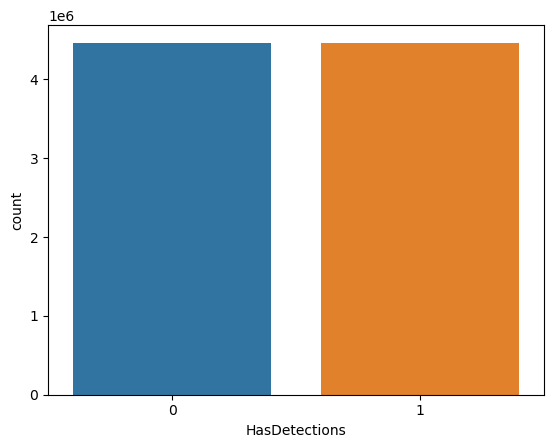

In [9]:
sns.countplot(x = train_df[label_col])

## 3. Preprocessing

In [10]:
train_df.drop(columns = ['MachineIdentifier'], inplace = True)

In [11]:
import sys

def preprocess_cat_values(df):
    temp = df.copy()
    
    cols = temp.select_dtypes(include = [object]).columns.tolist()   
    
    # use 'sys.intern' to reduce memory use
    # see why here: https://stackoverflow.com/questions/76104472/python-str-lower-causes-memory-leak
    temp[cols] = temp[cols].astype(str).apply(lambda x: x.str.lower().apply(sys.intern))
    
    os_build_lab_cat = 'OsBuildLab'
    if os_build_lab_cat in temp.columns:
        os_build_lab_df = temp[os_build_lab_cat].str.split(pat = '.', n = 5, expand = True)
        os_build_lab_df = os_build_lab_df.astype(str).apply(lambda x: x.str.lower().apply(sys.intern))
        os_build_lab_df = os_build_lab_df.add_prefix(os_build_lab_cat + '_')
        
        temp = pd.concat([temp, os_build_lab_df], axis = 1)
        temp = temp.drop(columns = os_build_lab_cat)
    
    smart_screen_cat = 'SmartScreen'
    if smart_screen_cat in temp.columns:
        temp.loc[temp[smart_screen_cat] == 'promt', smart_screen_cat] = 'prompt'
        temp.loc[temp[smart_screen_cat] == '00000000', smart_screen_cat] = '0'
        temp[smart_screen_cat] = temp[smart_screen_cat].astype(str).apply(sys.intern)
        
    disk_type_cat = 'Census_PrimaryDiskTypeName'
    if disk_type_cat in temp.columns:
        disk_types = ['HDD', 'SSD']
        temp.loc[~temp[disk_type_cat].isin(disk_types), disk_type_cat] == 'na'                                
        temp[disk_type_cat] = temp[disk_type_cat].astype(str).apply(sys.intern)
        
    role_name_cat = 'Census_PowerPlatformRoleName'
    if role_name_cat in temp.columns:
        na_types = ['unspecified', 'unknown', np.nan]
        temp.loc[temp[role_name_cat].isin(na_types), role_name_cat] == 'na'                             
        temp[role_name_cat] = temp[role_name_cat].astype(str).apply(sys.intern)
    
    return temp

In [12]:
train_df = preprocess_cat_values(train_df)

In [13]:
train_df.duplicated().sum()

7727

In [14]:
train_df.drop_duplicates(inplace = True)

In [15]:
y = train_df.pop(label_col)
y.shape

(8913756,)

In [16]:
str_cols = train_df.select_dtypes(include = 'object').columns
non_str_cols = train_df.select_dtypes(exclude = 'object').columns

In [17]:
na_value = -1

train_df[str_cols] = train_df[str_cols].fillna('na')
train_df[non_str_cols] = train_df[non_str_cols].fillna(na_value)
train_df.isna().sum()

ProductName         0
EngineVersion       0
AppVersion          0
AvSigVersion        0
RtpStateBitfield    0
                   ..
OsBuildLab_0        0
OsBuildLab_1        0
OsBuildLab_2        0
OsBuildLab_3        0
OsBuildLab_4        0
Length: 63, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size = 0.2, random_state = 42)

In [19]:
del train_df, y

In [20]:
cols = X_train.columns.tolist()

In [21]:
# encoding
from sklearn.preprocessing import OrdinalEncoder

unknown_value = -100
oe = OrdinalEncoder(handle_unknown = 'use_encoded_value', dtype = 'int32', unknown_value = unknown_value)
X_train_encoded = oe.fit_transform(X_train)
X_val_encoded = oe.transform(X_val)

In [22]:
max_vals = X_train_encoded.max(axis = 0) + 1
X_val_encoded = np.where(X_val_encoded == unknown_value, max_vals, X_val_encoded)

In [23]:
del X_train, X_val

## 4. LightGBM

### 4.1 Searching for the best parameters

In [24]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [25]:
X_sample, _, y_sample, _ = train_test_split(X_train_encoded, y_train, train_size = 0.1, random_state = 42)
X_sample.shape

(713100, 63)

In [26]:
parameters = {'max_depth' : [6, 7, 8], 
              'n_estimators': [550, 600, 650],
              'colsample_bytree' : [0.5, 0.6, 0.7],
              'num_leaves' : [60, 70, 80]
             }

clf = lgb.LGBMClassifier(learning_rate = 0.1)
grid_search_clf = GridSearchCV(clf, parameters)
grid_search_clf.fit(X_sample, y_sample)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7],
                         'max_depth': [6, 7, 8],
                         'n_estimators': [550, 600, 650],
                         'num_leaves': [60, 70, 80]})

In [27]:
grid_search_clf.best_params_

{'colsample_bytree': 0.5,
 'max_depth': 7,
 'n_estimators': 600,
 'num_leaves': 80}

### 4.2 Model fitting

In [28]:
clf_gb = grid_search_clf.best_estimator_

In [29]:
clf_gb.fit(X_train_encoded, y_train, 
           eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)],
           eval_names = ['train', 'val'],
           eval_metric ='auc',
           callbacks = [lgb.log_evaluation(50), lgb.early_stopping(5)])

Training until validation scores don't improve for 5 rounds
[50]	train's auc: 0.707335	train's binary_logloss: 0.620202	val's auc: 0.707102	val's binary_logloss: 0.62042
[100]	train's auc: 0.716615	train's binary_logloss: 0.613324	val's auc: 0.715958	val's binary_logloss: 0.613809
[150]	train's auc: 0.721365	train's binary_logloss: 0.609876	val's auc: 0.720359	val's binary_logloss: 0.610604
[200]	train's auc: 0.724486	train's binary_logloss: 0.607524	val's auc: 0.723105	val's binary_logloss: 0.608501
[250]	train's auc: 0.727229	train's binary_logloss: 0.605408	val's auc: 0.725526	val's binary_logloss: 0.606635
[300]	train's auc: 0.729261	train's binary_logloss: 0.603856	val's auc: 0.7272	val's binary_logloss: 0.605348
[350]	train's auc: 0.731074	train's binary_logloss: 0.602445	val's auc: 0.728652	val's binary_logloss: 0.6042
[400]	train's auc: 0.73264	train's binary_logloss: 0.601221	val's auc: 0.729855	val's binary_logloss: 0.603249
[450]	train's auc: 0.734011	train's binary_logloss:

LGBMClassifier(colsample_bytree=0.5, max_depth=7, n_estimators=600,
               num_leaves=80)

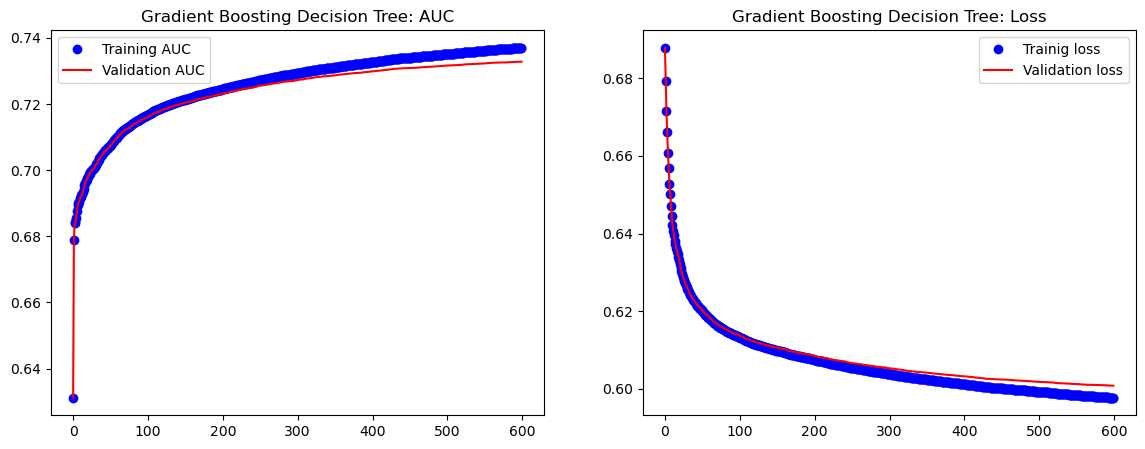

In [30]:
plt.figure(figsize=(14, 5))

# auc
train_auc = clf_gb.evals_result_['train']['auc']
val_auc = clf_gb.evals_result_['val']['auc']

plt.subplot(1,2,1)
plt.plot(train_auc,  'bo', label = 'Training AUC')
plt.plot(val_auc,  'r', label = 'Validation AUC')
plt.title('Gradient Boosting Decision Tree: AUC')
plt.legend()

# loss
train_loss = clf_gb.evals_result_['train']['binary_logloss']
val_loss = clf_gb.evals_result_['val']['binary_logloss']

plt.subplot(1,2,2)
plt.plot(train_loss, 'bo', label = 'Trainig loss')
plt.plot(val_loss, 'r', label = 'Validation loss')
plt.title('Gradient Boosting Decision Tree: Loss')
plt.legend()
    
plt.show()

In [31]:
del y_train, y_val, X_train_encoded, X_val_encoded

## 5. Test

In [32]:
test_df = pd.read_csv('/kaggle/input/microsoft-malware-prediction/test.csv',
                      usecols = lambda x: x not in columns_to_ignore,
                      dtype = column_dtypes)
test_df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,...,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsPenCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,0000010489e3af074adeac69c53e555e,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,7,0,53447.0,1.0,1.0,...,0,IS_GENUINE,OEM:DM,0,Retail,807.0,8554.0,0,0,7.0
1,00000176ac758d54827acd545b6315a5,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,7,0,53447.0,1.0,1.0,...,0,IS_GENUINE,Retail,0,Retail,554.0,33105.0,0,1,12.0
2,0000019dcefc128c2d4387c1273dae1d,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,7,0,49480.0,2.0,1.0,...,0,IS_GENUINE,OEM:DM,0,Retail,556.0,63396.0,0,1,11.0
3,0000055553dc51b1295785415f1a224d,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,7,0,42160.0,2.0,1.0,...,0,IS_GENUINE,OEM:DM,0,Retail,628.0,26320.0,0,0,10.0
4,00000574cefffeca83ec8adf9285b2bf,win8defender,1.1.15400.4,4.18.1809.2,1.279.236.0,7,0,53447.0,1.0,1.0,...,0,IS_GENUINE,Retail,0,Retail,556.0,63269.0,0,1,3.0


In [33]:
sub = test_df.pop('MachineIdentifier').to_frame()

In [34]:
test_df = preprocess_cat_values(test_df)

In [35]:
test_df[str_cols] = test_df[str_cols].fillna('na')
test_df[non_str_cols] = test_df[non_str_cols].fillna(na_value)
test_df.isna().sum()

ProductName         0
EngineVersion       0
AppVersion          0
AvSigVersion        0
RtpStateBitfield    0
                   ..
OsBuildLab_0        0
OsBuildLab_1        0
OsBuildLab_2        0
OsBuildLab_3        0
OsBuildLab_4        0
Length: 63, dtype: int64

In [36]:
test_df = oe.transform(test_df)
test_df = np.where(test_df == unknown_value, max_vals, test_df)

In [37]:
# predictions
sub[label_col] = clf_gb.predict_proba(test_df)[:, 1]
sub.head()

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.407217
1,00000176ac758d54827acd545b6315a5,0.507656
2,0000019dcefc128c2d4387c1273dae1d,0.466250
3,0000055553dc51b1295785415f1a224d,0.428849
4,00000574cefffeca83ec8adf9285b2bf,0.541166


In [38]:
sub.to_csv('submission.csv', index = False)